<a href="https://colab.research.google.com/github/muhammadtarek98/Graduation-project/blob/master/notebook/triple_MRInet_last_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import pdb
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
import os
import pickle
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from datetime import datetime
from pathlib import Path
from sklearn import metrics

In [4]:
class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(pretrained=True)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.squeeze(x, dim=0) # only batch size 1 supported
        x = self.model.features(x)
        x = self.gap(x).view(x.size(0), -1)
        x = torch.max(x, 0, keepdim=True)[0]
        x = self.classifier(x)
        return x

class TripleMRNet(nn.Module):
    def __init__(self, backbone="resnet18", training=True):
        super().__init__()
        self.backbone = backbone
        if self.backbone == "resnet18":
            resnet = models.resnet18(pretrained=training)
            modules = list(resnet.children())[:-1]
            self.axial_net = nn.Sequential(*modules)
            for param in self.axial_net.parameters():
                param.requires_grad = False
        elif self.backbone == "alexnet":
            self.axial_net = models.alexnet(pretrained=training)

        if self.backbone == "resnet18":
            resnet = models.resnet18(pretrained=training)
            modules = list(resnet.children())[:-1]
            self.sagit_net = nn.Sequential(*modules)
            for param in self.sagit_net.parameters():
                param.requires_grad = False
        elif self.backbone == "alexnet":
            self.sagit_net = models.alexnet(pretrained=training)
        
        if self.backbone == "resnet18":
            resnet = models.resnet18(pretrained=training)
            modules = list(resnet.children())[:-1]
            self.coron_net = nn.Sequential(*modules)
            for param in self.coron_net.parameters():
                param.requires_grad = False
        elif self.backbone == "alexnet":
            self.coron_net = models.alexnet(pretrained=training)

        self.gap_axial = nn.AdaptiveAvgPool2d(1)
        self.gap_sagit = nn.AdaptiveAvgPool2d(1)
        self.gap_coron = nn.AdaptiveAvgPool2d(1)
       
        if self.backbone == "resnet18":
            self.classifier = nn.Linear(3*512, 1)
        elif self.backbone == "alexnet":
            self.classifier = nn.Linear(3*256, 1)

    def forward(self, vol_axial, vol_sagit, vol_coron):
        vol_axial = torch.squeeze(vol_axial, dim=0)
        vol_sagit = torch.squeeze(vol_sagit, dim=0)
        vol_coron = torch.squeeze(vol_coron, dim=0)
       
        if self.backbone == "resnet18":
            vol_axial = self.axial_net(vol_axial)
            vol_sagit = self.sagit_net(vol_sagit)
            vol_coron = self.coron_net(vol_coron)
        elif self.backbone == "alexnet":
            vol_axial = self.axial_net.features(vol_axial)
            vol_sagit = self.sagit_net.features(vol_sagit)
            vol_coron = self.coron_net.features(vol_coron)

        vol_axial = self.gap_axial(vol_axial).view(vol_axial.size(0), -1)
        x = torch.max(vol_axial, 0, keepdim=True)[0]
        vol_sagit = self.gap_sagit(vol_sagit).view(vol_sagit.size(0), -1)
        y = torch.max(vol_sagit, 0, keepdim=True)[0]
        vol_coron = self.gap_coron(vol_coron).view(vol_coron.size(0), -1)
        z = torch.max(vol_coron, 0, keepdim=True)[0]

        w = torch.cat((x, y, z), 1)
        out = self.classifier(w)
        return out

In [5]:
class MRI_alex(nn.Module):
  def __init__(self, training=True):
    super().__init__()
    self.axial_net = models.alexnet(pretrained=training)
    self.sagit_net = models.alexnet(pretrained=training)
    self.coron_net = models.alexnet(pretrained=training)

    self.gap_axial = nn.AdaptiveAvgPool2d(1)
    self.gap_sagit = nn.AdaptiveAvgPool2d(1)
    self.gap_coron = nn.AdaptiveAvgPool2d(1)
    self.classifier = nn.Linear(3*256, 1)

  def forward(self,vol_axial, vol_sagit, vol_coron):
    vol_axial = torch.squeeze(vol_axial, dim=0)
    vol_sagit = torch.squeeze(vol_sagit, dim=0)
    vol_coron = torch.squeeze(vol_coron, dim=0)

    vol_axial = self.axial_net.features(vol_axial)
    vol_sagit = self.sagit_net.features(vol_sagit)
    vol_coron = self.coron_net.features(vol_coron)

    vol_axial = self.gap_axial(vol_axial).view(vol_axial.size(0), -1)
    x = torch.max(vol_axial, 0, keepdim=True)[0]

    vol_sagit = self.gap_sagit(vol_sagit).view(vol_sagit.size(0), -1)
    y = torch.max(vol_sagit, 0, keepdim=True)[0]

    vol_coron = self.gap_coron(vol_coron).view(vol_coron.size(0), -1)
    z = torch.max(vol_coron, 0, keepdim=True)[0]

    w = torch.cat((x, y, z), 1)
    out = self.classifier(w)
    return out

In [6]:
def preprocess(series):
        pad = int((series.shape[2] - INPUT_DIM)/2)
        series = series[:,pad:-pad,pad:-pad]
        series = (series-np.min(series))/(np.max(series)-np.min(series))*MAX_PIXEL_VAL
        series = (series - MEAN) / STDDEV
        series = np.stack((series,)*3, axis=1)
        series_float = torch.FloatTensor(series)
        return series_float

In [7]:
INPUT_DIM = 224
MAX_PIXEL_VAL = 255
MEAN = 58.09
STDDEV = 49.73
class Dataset(data.Dataset):
    def __init__(self, datadir, tear_type, use_gpu):
        super().__init__()
        self.use_gpu = use_gpu
        label_dict = {}
        self.paths = []
        abnormal_label_dict = {}
        if datadir[-1]=="/":
            datadir = datadir[:-1]
        self.datadir = datadir
        for i, line in enumerate(open(datadir+'-'+tear_type+'.csv').readlines()):
            line = line.strip().split(',')
            filename = line[0]
            label = line[1]
            label_dict[filename] = int(label)
        

        for i, line in enumerate(open(datadir+'-'+"abnormal"+'.csv').readlines()):
            line = line.strip().split(',')
            filename = line[0]
            label = line[1]
            abnormal_label_dict[filename] = int(label)

        for filename in os.listdir(os.path.join(datadir, "axial")):
            if filename.endswith(".npy"):
                self.paths.append(filename)
        
        self.labels = [label_dict[path.split(".")[0]] for path in self.paths]
        self.abnormal_labels = [abnormal_label_dict[path.split(".")[0]] for path in self.paths]

        if tear_type != "abnormal":
            temp_labels = [self.labels[i] for i in range(len(self.labels)) if self.abnormal_labels[i]==1]
            neg_weight = np.mean(temp_labels)
        else:
            neg_weight = np.mean(self.labels)
        
        self.weights = [neg_weight, 1 - neg_weight]

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(prediction, target, weight=Variable(weights_tensor))
        return loss

    def __getitem__(self, index):
        filename = self.paths[index]
        vol_axial = np.load(os.path.join(self.datadir, "axial", filename))
        vol_sagit = np.load(os.path.join(self.datadir, "sagittal", filename))
        vol_coron = np.load(os.path.join(self.datadir, "coronal", filename))

        # axial
        vol_axial_tensor = preprocess(vol_axial)
        
        # sagittal
        vol_sagit_tensor = preprocess(vol_sagit)

        # coronal
        vol_coron_tensor = preprocess(vol_coron)

        label_tensor = torch.FloatTensor([self.labels[index]])

        return vol_axial_tensor, vol_sagit_tensor, vol_coron_tensor, label_tensor, self.abnormal_labels[index]

    def __len__(self):
        return len(self.paths)

def load_data(task, use_gpu):
    train_dir = "/content/drive/My Drive/MRNet-v1.0/train"
    valid_dir = "/content/drive/My Drive/MRNet-v1.0/valid"
    
    train_dataset = Dataset(train_dir, task, use_gpu)
    valid_dataset = Dataset(valid_dir, task, use_gpu)

    train_loader = data.DataLoader(train_dataset, batch_size=1, num_workers=11, shuffle=True)
    valid_loader = data.DataLoader(valid_dataset, batch_size=1, num_workers=11, shuffle=False)

    return train_loader, valid_loader

In [8]:
def run_model(model, loader, train=False, optimizer=None,abnormal_model_path=None):
    preds = []
    labels = []

    if train:
        model.train()
    else:
        if abnormal_model_path:
            abnormal_model = MRI_alex(train)
            state_dict = torch.load(abnormal_model_path)
            abnormal_model.load_state_dict(state_dict)
            abnormal_model.cuda()
            abnormal_model.eval()
        model.eval()

    total_loss = 0.0
    num_batches = 0

    for batch in tqdm(loader):
        vol_axial, vol_sagit, vol_coron, label, abnormal = batch
        if train:
            if abnormal_model_path and not abnormal:
                continue
            optimizer.zero_grad()
        if loader.dataset.use_gpu:
            vol_axial, vol_sagit, vol_coron = vol_axial.cuda(), vol_sagit.cuda(), vol_coron.cuda()
            label = label.cuda()
        vol_axial, vol_sagit, vol_coron = Variable(vol_axial), Variable(vol_sagit), Variable(vol_coron)
        label = Variable(label)

        logit = model.forward(vol_axial, vol_sagit, vol_coron)

        loss = loader.dataset.weighted_loss(logit, label)
        total_loss += loss.item()

        pred = torch.sigmoid(logit)

        pred_npy = pred.data.cpu().numpy()[0][0]

        if abnormal_model_path and not train:
            abnormal_logit = abnormal_model.forward(vol_axial,vol_sagit,vol_coron)
            abnormal_pred = torch.sigmoid(abnormal_logit)
            abnormal_pred_npy = abnormal_pred.data.cpu().numpy()[0][0]
            pred_npy = pred_npy * abnormal_pred_npy

        label_npy = label.data.cpu().numpy()[0][0]

        preds.append(pred_npy)
        labels.append(label_npy)

        if train:
            loss.backward()
            optimizer.step()
        num_batches += 1

    avg_loss = total_loss / num_batches
    
    fpr, tpr, threshold = metrics.roc_curve(labels, preds)
    auc = metrics.auc(fpr, tpr)

    if abnormal_model_path and not train:
        del abnormal_model

    return avg_loss, auc, preds, labels

def evaluate(split, model_path, diagnosis, use_gpu):
    train_loader, valid_loader, test_loader = load_data(diagnosis, use_gpu)

    model = MRI_alex()
    state_dict = torch.load(model_path, map_location=(None if use_gpu else 'cpu'))
    model.load_state_dict(state_dict)

    if use_gpu:
        model = model.cuda()

    if split == 'train':
        loader = train_loader
    elif split == 'valid':
        loader = valid_loader
    elif split == 'test':
        loader = test_loader
    else:
        raise ValueError("split must be 'train', 'valid', or 'test'")

    loss, auc, preds, labels = run_model(model, loader)

    print(f'{split} loss: {loss:0.4f}')
    print(f'{split} AUC: {auc:0.4f}')

    return preds, labels

In [9]:
def train(rundir, task, epochs, learning_rate, use_gpu,model,abnormal_model_path=None):
    train_loader, valid_loader = load_data(task, use_gpu)
    model = model
    train_loss_list=[]
    val_loss_list=[]
    train_auc_list=[]
    val_auc_list=[]
    '''for dirpath, dirnames, files in os.walk(rundir):
        if not files:
            break
        max_epoch = 0
        model_path = None
        for fname in files:
            if fname.endswith(".json"):
                continue
            ep = int(fname[27:])
            if ep >= max_epoch:
                max_epoch = ep
                model_path = os.path.join(dirpath, fname)
        
        if model_path:
            state_dict = torch.load(model_path, map_location=(None if use_gpu else 'cpu'))
            model.load_state_dict(state_dict)
'''
    if use_gpu:
        model = model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.3, threshold=1e-4)
    best_val_loss = float('inf')
    start_time = datetime.now()
    for epoch in range(epochs):
        change = datetime.now() - start_time
        print('starting epoch {}. time passed: {}'.format(epoch+1, str(change)))
        train_loss, train_auc, _, _ = run_model(model, train_loader, train=True, optimizer=optimizer,abnormal_model_path=abnormal_model_path)
        train_loss_list.append(train_loss)
        train_auc_list.append(train_auc)
        print(f'train loss: {train_loss:0.4f}')
        print(f'train AUC: {train_auc:0.4f}')
        val_loss, val_auc, _, _ = run_model(model, valid_loader,abnormal_model_path=abnormal_model_path)
        val_loss_list.append(val_loss)
        val_auc_list.append(val_auc)
        print(f'valid loss: {val_loss:0.4f}')
        print(f'valid AUC: {val_auc:0.4f}')
        scheduler.step(val_loss)
    return train_loss_list,train_auc_list,val_loss_list,val_auc_list

In [10]:
model_acl=MRI_alex(training=True)
model_men=MRI_alex(training=True)
model_ab=MRI_alex(training=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [47]:
num_epoch=20
train_loss,train_auc,val_loss,val_auc=train('/content/drive/My Drive/MRNet-v1.0/temp',task='abnormal',epochs=num_epoch,learning_rate=1e-5,use_gpu='cuda',model=model_ab)

  0%|          | 0/1130 [00:00<?, ?it/s]

starting epoch 1. time passed: 0:00:00.000014


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.1759
train AUC: 0.7820


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.1673
valid AUC: 0.8947
starting epoch 2. time passed: 0:08:21.883323


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.1316
train AUC: 0.8910


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.1359
valid AUC: 0.9419
starting epoch 3. time passed: 0:12:46.573747


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.1097
train AUC: 0.9250


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.1372
valid AUC: 0.9364
starting epoch 4. time passed: 0:17:11.337285


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.1005
train AUC: 0.9395


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.2615
valid AUC: 0.9436
starting epoch 5. time passed: 0:22:52.727333


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.0928
train AUC: 0.9465


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.1054
valid AUC: 0.9436
starting epoch 6. time passed: 0:28:19.061674


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.0863
train AUC: 0.9552


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.1003
valid AUC: 0.9516
starting epoch 7. time passed: 0:33:13.536284


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.0918
train AUC: 0.9477


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.0980
valid AUC: 0.9503
starting epoch 8. time passed: 0:38:56.248676


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.0888
train AUC: 0.9529


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.1087
valid AUC: 0.9520
starting epoch 9. time passed: 0:44:36.687770


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.0853
train AUC: 0.9573


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.1139
valid AUC: 0.9533
starting epoch 10. time passed: 0:52:57.783411


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.0857
train AUC: 0.9573


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.1027
valid AUC: 0.9457
starting epoch 11. time passed: 0:59:38.690902


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.0877
train AUC: 0.9561


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.1022
valid AUC: 0.9512
starting epoch 12. time passed: 1:04:09.125320


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.0876
train AUC: 0.9533


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.1194
valid AUC: 0.9507
starting epoch 13. time passed: 1:09:16.592457


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.0876
train AUC: 0.9543


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.1156
valid AUC: 0.9402
starting epoch 14. time passed: 1:16:19.703370


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.0757
train AUC: 0.9723


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.1080
valid AUC: 0.9486
starting epoch 15. time passed: 1:30:31.915759


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.0753
train AUC: 0.9706


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.1492
valid AUC: 0.9478
starting epoch 16. time passed: 1:39:32.075996


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.0744
train AUC: 0.9704


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.1157
valid AUC: 0.9482
starting epoch 17. time passed: 1:48:18.734735


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.0740
train AUC: 0.9708


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.2482
valid AUC: 0.9448
starting epoch 18. time passed: 1:52:47.882889


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.0733
train AUC: 0.9718


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.1208
valid AUC: 0.9486
starting epoch 19. time passed: 1:57:17.742002


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.0739
train AUC: 0.9725


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.1346
valid AUC: 0.9461
starting epoch 20. time passed: 2:04:11.717334


  0%|          | 0/120 [00:00<?, ?it/s]

train loss: 0.0686
train AUC: 0.9772


100%|██████████| 120/120 [00:28<00:00,  4.18it/s]

valid loss: 0.1229
valid AUC: 0.9478


In [55]:
torch.save(model_ab.state_dict(), '/content/drive/My Drive/MRNet-v1.0/temp/abnormal.pt')

In [ ]:
model_ab

In [11]:
def plotting_graph(x_axis,y_axis,x_title,y_title,graph_title):
    x_axis=np.array([i+1 for i in range(x_axis)])
    y_axis=np.array(y_axis)
    plt.plot(x_axis, y_axis, 'r-^')
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title(graph_title)
    plt.grid()
    plt.show()
    plt.savefig(fname="/content/drive/My Drive/MRNet-v1.0/temp/{}.jpg".format(graph_title))

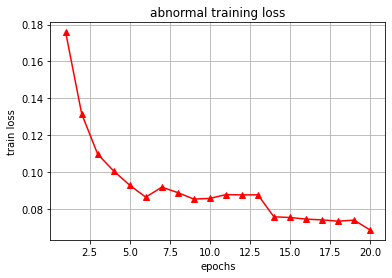

<Figure size 432x288 with 0 Axes>

In [51]:
plotting_graph(num_epoch,train_loss,"epochs","train loss","abnormal training loss")

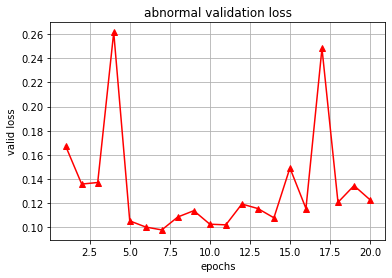

<Figure size 432x288 with 0 Axes>

In [52]:
plotting_graph(num_epoch,val_loss,"epochs","valid loss","abnormal validation loss")

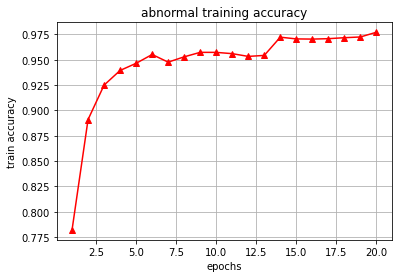

<Figure size 432x288 with 0 Axes>

In [53]:
plotting_graph(num_epoch,train_auc,"epochs","train accuracy","abnormal training accuracy")

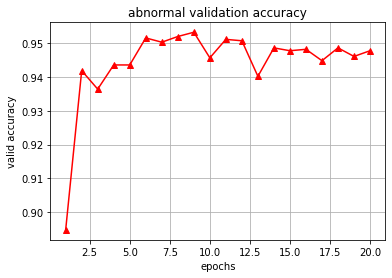

<Figure size 432x288 with 0 Axes>

In [54]:
plotting_graph(num_epoch,val_auc,"epochs","valid accuracy","abnormal validation accuracy")

In [12]:
num_epoch=40
train_loss,train_auc,val_loss,val_auc=train('/content/drive/My Drive/MRNet-v1.0/temp',task='meniscus',epochs=num_epoch,learning_rate=1e-6,use_gpu='cuda',model=model_men,abnormal_model_path='/content/drive/My Drive/MRNet-v1.0/temp/abnormal.pt')

  0%|          | 0/1130 [00:00<?, ?it/s]

starting epoch 1. time passed: 0:00:00.000014


100%|██████████| 1130/1130 [04:44<00:00,  3.97it/s]


train loss: 0.3540
train AUC: 0.4656


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3707
valid AUC: 0.7800
starting epoch 2. time passed: 0:05:49.665522


100%|██████████| 1130/1130 [03:48<00:00,  4.94it/s]


train loss: 0.3353
train AUC: 0.5837


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3445
valid AUC: 0.7910
starting epoch 3. time passed: 0:10:28.262630


100%|██████████| 1130/1130 [03:49<00:00,  4.93it/s]


train loss: 0.3228
train AUC: 0.6822


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3508
valid AUC: 0.8057
starting epoch 4. time passed: 0:15:09.704378


100%|██████████| 1130/1130 [03:52<00:00,  4.86it/s]


train loss: 0.3129
train AUC: 0.7421


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3260
valid AUC: 0.8066
starting epoch 5. time passed: 0:19:55.828026


100%|██████████| 1130/1130 [04:00<00:00,  4.70it/s]


train loss: 0.3038
train AUC: 0.7772


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3257
valid AUC: 0.8119
starting epoch 6. time passed: 0:24:47.996265


100%|██████████| 1130/1130 [03:50<00:00,  4.90it/s]


train loss: 0.2962
train AUC: 0.8115


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3246
valid AUC: 0.8091
starting epoch 7. time passed: 0:29:28.824815


100%|██████████| 1130/1130 [03:52<00:00,  4.85it/s]


train loss: 0.2873
train AUC: 0.8250


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3086
valid AUC: 0.8102
starting epoch 8. time passed: 0:34:12.069903


100%|██████████| 1130/1130 [03:51<00:00,  4.88it/s]


train loss: 0.2837
train AUC: 0.8330


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3139
valid AUC: 0.8122
starting epoch 9. time passed: 0:38:55.806005


100%|██████████| 1130/1130 [03:55<00:00,  4.81it/s]


train loss: 0.2757
train AUC: 0.8510


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3465
valid AUC: 0.8156
starting epoch 10. time passed: 0:43:41.370585


100%|██████████| 1130/1130 [03:51<00:00,  4.89it/s]


train loss: 0.2695
train AUC: 0.8498


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3378
valid AUC: 0.8153
starting epoch 11. time passed: 0:48:24.427580


100%|██████████| 1130/1130 [03:56<00:00,  4.77it/s]


train loss: 0.2652
train AUC: 0.8655


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3316
valid AUC: 0.8136
starting epoch 12. time passed: 0:53:14.810787


100%|██████████| 1130/1130 [03:50<00:00,  4.91it/s]


train loss: 0.2607
train AUC: 0.8730


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3142
valid AUC: 0.8114
starting epoch 13. time passed: 0:58:00.086554


100%|██████████| 1130/1130 [04:00<00:00,  4.69it/s]


train loss: 0.2570
train AUC: 0.8765


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3145
valid AUC: 0.8119
starting epoch 14. time passed: 1:02:54.474145


100%|██████████| 1130/1130 [03:53<00:00,  4.85it/s]


train loss: 0.2500
train AUC: 0.8988


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3079
valid AUC: 0.8117
starting epoch 15. time passed: 1:08:38.839145


100%|██████████| 1130/1130 [03:52<00:00,  4.87it/s]


train loss: 0.2482
train AUC: 0.8999


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3064
valid AUC: 0.8108
starting epoch 16. time passed: 1:13:21.675607


100%|██████████| 1130/1130 [03:50<00:00,  4.91it/s]


train loss: 0.2472
train AUC: 0.9024


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3040
valid AUC: 0.8111
starting epoch 17. time passed: 1:18:05.322607


100%|██████████| 1130/1130 [04:53<00:00,  3.86it/s]


train loss: 0.2457
train AUC: 0.9034


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.2990
valid AUC: 0.8094
starting epoch 18. time passed: 1:23:49.452875


100%|██████████| 1130/1130 [03:50<00:00,  4.91it/s]


train loss: 0.2449
train AUC: 0.9018


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3000
valid AUC: 0.8102
starting epoch 19. time passed: 1:28:32.453082


100%|██████████| 1130/1130 [04:50<00:00,  3.89it/s]


train loss: 0.2432
train AUC: 0.9065


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3021
valid AUC: 0.8105
starting epoch 20. time passed: 1:34:13.921659


100%|██████████| 1130/1130 [03:52<00:00,  4.87it/s]


train loss: 0.2420
train AUC: 0.9081


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3014
valid AUC: 0.8111
starting epoch 21. time passed: 1:38:59.069641


100%|██████████| 1130/1130 [03:53<00:00,  4.84it/s]


train loss: 0.2406
train AUC: 0.9099


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.2975
valid AUC: 0.8100
starting epoch 22. time passed: 1:43:43.423610


100%|██████████| 1130/1130 [03:53<00:00,  4.84it/s]


train loss: 0.2399
train AUC: 0.9100


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.2988
valid AUC: 0.8111
starting epoch 23. time passed: 1:48:29.208461


100%|██████████| 1130/1130 [03:55<00:00,  4.80it/s]


train loss: 0.2382
train AUC: 0.9124


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3024
valid AUC: 0.8122
starting epoch 24. time passed: 1:53:15.693764


100%|██████████| 1130/1130 [04:06<00:00,  4.58it/s]


train loss: 0.2371
train AUC: 0.9149


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3007
valid AUC: 0.8117
starting epoch 25. time passed: 1:58:13.222587


100%|██████████| 1130/1130 [03:58<00:00,  4.74it/s]


train loss: 0.2360
train AUC: 0.9156


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3001
valid AUC: 0.8117
starting epoch 26. time passed: 2:03:04.878065


100%|██████████| 1130/1130 [03:55<00:00,  4.79it/s]


train loss: 0.2346
train AUC: 0.9161


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.2963
valid AUC: 0.8117
starting epoch 27. time passed: 2:07:53.128789


100%|██████████| 1130/1130 [04:12<00:00,  4.48it/s]


train loss: 0.2333
train AUC: 0.9200


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.2949
valid AUC: 0.8111
starting epoch 28. time passed: 2:12:59.929534


100%|██████████| 1130/1130 [05:04<00:00,  3.71it/s]


train loss: 0.2326
train AUC: 0.9196


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.2950
valid AUC: 0.8125
starting epoch 29. time passed: 2:18:58.357603


100%|██████████| 1130/1130 [03:59<00:00,  4.72it/s]


train loss: 0.2311
train AUC: 0.9224


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3054
valid AUC: 0.8162
starting epoch 30. time passed: 2:23:48.701210


100%|██████████| 1130/1130 [03:55<00:00,  4.80it/s]


train loss: 0.2304
train AUC: 0.9219


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3032
valid AUC: 0.8165
starting epoch 31. time passed: 2:28:35.741600


100%|██████████| 1130/1130 [03:56<00:00,  4.77it/s]


train loss: 0.2287
train AUC: 0.9230


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3033
valid AUC: 0.8170
starting epoch 32. time passed: 2:33:25.237456


100%|██████████| 1130/1130 [03:52<00:00,  4.85it/s]


train loss: 0.2277
train AUC: 0.9239


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.2942
valid AUC: 0.8136
starting epoch 33. time passed: 2:38:08.698740


100%|██████████| 1130/1130 [03:50<00:00,  4.90it/s]


train loss: 0.2270
train AUC: 0.9241


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.2948
valid AUC: 0.8156
starting epoch 34. time passed: 2:42:56.680142


100%|██████████| 1130/1130 [03:53<00:00,  4.84it/s]


train loss: 0.2259
train AUC: 0.9280


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3017
valid AUC: 0.8182
starting epoch 35. time passed: 2:47:41.493231


100%|██████████| 1130/1130 [03:51<00:00,  4.89it/s]


train loss: 0.2248
train AUC: 0.9268


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.2928
valid AUC: 0.8148
starting epoch 36. time passed: 2:52:23.980329


100%|██████████| 1130/1130 [04:04<00:00,  4.62it/s]


train loss: 0.2236
train AUC: 0.9303


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.3048
valid AUC: 0.8179
starting epoch 37. time passed: 2:57:18.822042


100%|██████████| 1130/1130 [03:54<00:00,  4.82it/s]


train loss: 0.2225
train AUC: 0.9303


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.2983
valid AUC: 0.8173
starting epoch 38. time passed: 3:02:07.203004


100%|██████████| 1130/1130 [03:58<00:00,  4.74it/s]


train loss: 0.2217
train AUC: 0.9319


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.2967
valid AUC: 0.8173
starting epoch 39. time passed: 3:06:52.457005


100%|██████████| 1130/1130 [03:55<00:00,  4.80it/s]


train loss: 0.2206
train AUC: 0.9331


  0%|          | 0/1130 [00:00<?, ?it/s]

valid loss: 0.2987
valid AUC: 0.8179
starting epoch 40. time passed: 3:11:35.956819


100%|██████████| 1130/1130 [03:52<00:00,  4.85it/s]


train loss: 0.2194
train AUC: 0.9365


100%|██████████| 120/120 [00:30<00:00,  3.92it/s]

valid loss: 0.3013
valid AUC: 0.8182


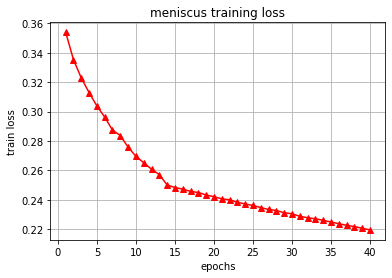

<Figure size 432x288 with 0 Axes>

In [13]:
plotting_graph(num_epoch,train_loss,"epochs","train loss","meniscus training loss")

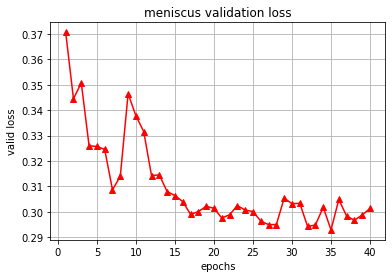

<Figure size 432x288 with 0 Axes>

In [14]:
plotting_graph(num_epoch,val_loss,"epochs","valid loss","meniscus validation loss")

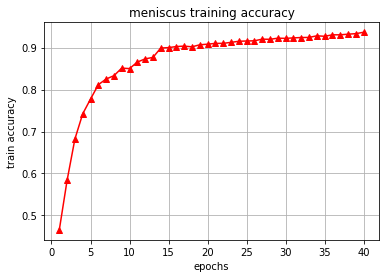

<Figure size 432x288 with 0 Axes>

In [15]:
plotting_graph(num_epoch,train_auc,"epochs","train accuracy","meniscus training accuracy")

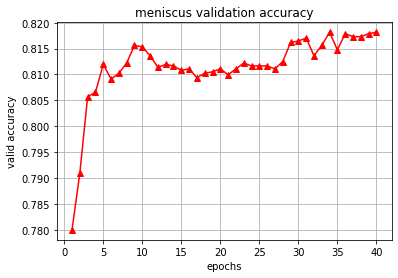

<Figure size 432x288 with 0 Axes>

In [16]:
plotting_graph(num_epoch,val_auc,"epochs","valid accuracy","meniscus validation accuracy")

In [17]:
torch.save(model_men.state_dict(), '/content/drive/My Drive/MRNet-v1.0/temp/meniscus.pt')

In [ ]:
def preprocess(series):
        pad = int((series.shape[2] - INPUT_DIM)/2)
        series = series[:,pad:-pad,pad:-pad]
        series = (series-np.min(series))/(np.max(series)-np.min(series))*MAX_PIXEL_VAL
        series = (series - MEAN) / STDDEV
        series = np.stack((series,)*3, axis=1)
        series_float = torch.FloatTensor(series)
        return series_float

def get_study(axial_path, sagit_path, coron_path):
    vol_axial = np.load(axial_path)
    vol_sagit = np.load(sagit_path)
    vol_coron = np.load(coron_path)
    # axial
    vol_axial_tensor = preprocess(vol_axial)
    # sagittal
    vol_sagit_tensor =preprocess(vol_sagit)
    # coronal
    vol_coron_tensor = preprocess(vol_coron)
    
    return {"axial": vol_axial_tensor,
            "sagit": vol_sagit_tensor,
            "coron": vol_coron_tensor}


def get_prediction(model, tensors, abnormality_prior=None):
    vol_axial = tensors["axial"].cuda()
    vol_sagit = tensors["sagit"].cuda()
    vol_coron = tensors["coron"].cuda()

    vol_axial = Variable(vol_axial)
    vol_sagit = Variable(vol_sagit)
    vol_coron = Variable(vol_coron)

    logit = model.forward(vol_axial, vol_sagit, vol_coron)
    pred = torch.sigmoid(logit)
    pred_npy = pred.data.cpu().numpy()[0][0]
    
    if abnormality_prior:
        pred_npy = pred_npy * abnormality_prior

    return pred_npy


def lets_predict3()
    # Assuming that the input csv has all three views for each ID.
    # And that entries are sorted by ID.
    views = []
    for i, fpath in enumerate(open(input_csv_path).readlines()):
        if "axial" in fpath:
            axial_path = fpath.strip()
        elif "sagittal" in fpath:
            sagit_path = fpath.strip()
        elif "coronal" in fpath:
            coron_path = fpath.strip()
        if i%3==2:
            views.append(get_study(axial_path, sagit_path, coron_path))


    # Loading all models
    abnormal_model_path = "src/abnormal_triple_alex/val0.1071_train0.0868_epoch8"
    acl_model_path = "src/acl_triple_alex/val0.1310_train0.0504_epoch30"
    meniscal_model_path = "src/meniscal_triple_alex/val0.2645_train0.1142_epoch22"


    # Getting predictions
    abnormality = []
    acl_tear = []
    meniscal_tear = []
    
    abnormal_model = MRI_alex( training=False)
    state_dict = torch.load(abnormal_model_path)
    abnormal_model.load_state_dict(state_dict)
    abnormal_model.cuda()
    abnormal_model.eval()
    for study in views:
        abnormality.append(get_prediction(
                abnormal_model,
                study,
                abnormality_prior=None))
    del abnormal_model

    acl_model = MRI_alex( training=False)
    state_dict = torch.load(acl_model_path)
    acl_model.load_state_dict(state_dict)
    acl_model.cuda()
    acl_model.eval()
    for idx,study in enumerate(views):
        acl_tear.append(get_prediction(
                acl_model,
                study,
                abnormality_prior=abnormality[idx]))
    del acl_model

    meniscal_model = MRI_alex(training=False)
    state_dict = torch.load(meniscal_model_path)
    meniscal_model.load_state_dict(state_dict)
    meniscal_model.cuda()
    meniscal_model.eval()
    for idx,study in enumerate(views):
        meniscal_tear.append(get_prediction(
                meniscal_model,
                study,
                abnormality_prior=abnormality[idx]))
    del meniscal_model
    

    with open(preds_csv_path, "w") as csv_file:        
        for i in range(len(abnormality)):
            csv_file.write(",".join(
                [str(abnormality[i]), str(acl_tear[i]), str(meniscal_tear[i])]))
            csv_file.write("\n"

In [ ]:
get_prediction(model_ab,get_study("/content/drive/My Drive/MRNet-v1.0/valid/axial/1135.npy","/content/drive/My Drive/MRNet-v1.0/valid/sagittal/1135.npy","/content/drive/My Drive/MRNet-v1.0/valid/coronal/1135.npy"))

0.6930317